# Compare WO summaries with buffering on and off

In [1]:
import datacube
import matplotlib.pyplot as plt
from odc.algo import mask_cleanup
from datacube.utils import masking
from datacube.utils.cog import write_cog

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import wofs_fuser
from dea_tools.dask import create_local_dask_cluster

### Load data

In [2]:
dc = datacube.Datacube(app='WO_cloud_buffering')

# Create local dask cluster
client = create_local_dask_cluster(return_client=True)


Client Scheduler: tcp://127.0.0.1:34029 Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Cluster Workers: 1 Cores: 31 Memory: 254.70 GB


In [3]:
# Tasmania
ymin, xmax = -41.15, 145.53
ymax, xmin = -41.28, 145.70

# # Melbourne
# ymin, xmax = -37.79261, 144.88339
# ymax, xmin = -37.89217, 145.04571

# # Glenelg
# ymin, xmax = -37.95629, 140.93265
# ymax, xmin = -38.09043, 141.07367

# Set up a region to load data
query = {
    'y': (ymin, ymax),
    'x': (xmin, xmax),
    'time': ('1987', '2021'),
}

# Load DEA Water Observations data from the datacube
wo = dc.load(product='ga_ls_wo_3',
             output_crs='EPSG:3577',
             resolution=(-30, 30),
             group_by='solar_day',
             fuse_func=wofs_fuser,
             dask_chunks={},
             **query)

# Load using dask
wo.load()

<xarray.Dataset>
Dimensions:      (time: 1611, y: 521, x: 534)
Coordinates:
  * time         (time) datetime64[ns] 1987-08-24T23:24:46.820967 ... 2021-12...
  * y            (y) float64 -4.561e+06 -4.561e+06 ... -4.576e+06 -4.576e+06
  * x            (x) float64 1.156e+06 1.156e+06 ... 1.172e+06 1.172e+06
    spatial_ref  int32 3577
Data variables:
    water        (time, y, x) uint8 64 64 64 64 64 64 80 80 ... 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Wet pixels

In [4]:
# Create water mask
wo_wet = masking.make_mask(wo, wet=True).water

### Calculate frequency without buffering
Calculate all-time frequency using unbuffered Fmask flags.

In [6]:
# Generate clouds/shadows mask
clouds_shadows = (masking.make_mask(wo, cloud=True) | masking.make_mask(wo, cloud_shadow=True)).water

# Combine clouds/shadows with terrain shadow mask
terrain_shadow = masking.make_mask(wo, terrain_shadow=True).water
bad_data = clouds_shadows | terrain_shadow

# Apply bad data mask 
wo_masked = wo_wet.where(~bad_data)

# Calculate frequency
flood_freq_nobuffer = wo_masked.mean(dim='time')

### Calculate frequency with buffering
For simplicity, a 10 pixel buffer is applied to all cloud/shadow pixels. 
By default, Fmask applies a 5 pixel buffer to clouds, and a 10 pixel buffer to shadow pixels.

(The current `stats` code includes the ability to mask clouds, shadows and terrain shadow)

In [8]:
# Generate buffered clouds/shadows mask
clouds_shadows = (masking.make_mask(wo, cloud=True) | masking.make_mask(wo, cloud_shadow=True)).water
clouds_shadows = mask_cleanup(clouds_shadows, mask_filters=[('dilation', 10)])

# Combine buffered clouds/shadows with terrain shadow mask
terrain_shadow = masking.make_mask(wo, terrain_shadow=True).water
bad_data = clouds_shadows | terrain_shadow

# Apply bad data mask 
wo_masked = wo_wet.where(~bad_data)

# Calculate frequency
flood_freq_buffer = wo_masked.mean(dim='time')

### Plot comparison

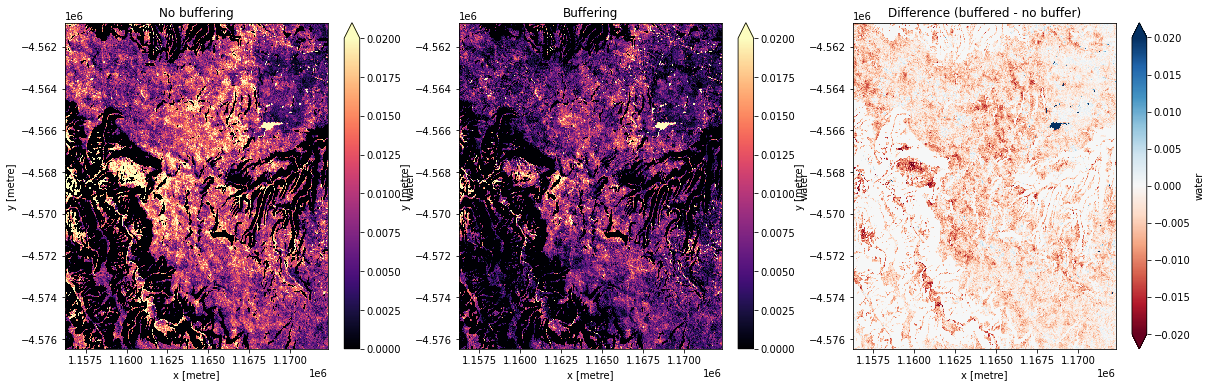

In [9]:
scale = 0.02
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
flood_freq_nobuffer.plot(ax=axes[0], vmin=0, vmax=scale, cmap='magma')
flood_freq_buffer.plot(ax=axes[1], vmin=0, vmax=scale, cmap='magma')
(flood_freq_buffer - flood_freq_nobuffer).plot(ax=axes[2],
                                               vmin=-scale,
                                               vmax=scale,
                                               cmap='RdBu')
axes[0].set_title('No buffering')
axes[1].set_title('Buffering')
axes[2].set_title('Difference (buffered - no buffer)')
fig.savefig('WO_freq_buffering_comparison.png', dpi=300, pad_inches='tight', facecolor='white')

In [ ]:
# Export to file
write_cog(flood_freq_buffer, 'freq_buffer.tif', overwrite=True)
write_cog(flood_freq_nobuffer, 'freq_nobuffer.tif', overwrite=True)

## Summary

Turning on cloud and cloud shadow buffering does not remove noise/false positives entirely, but does significantly reduce them (in many locations by between 50-200%).